# 0. Basic Model Pipeline

In [1]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:,.2f}'.format)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
label_encoder = LabelEncoder()

dtf = pd.read_csv("./data/survey_results_public.csv",index_col='ResponseId', encoding='utf-8')
cols = ["MainBranch","Age","RemoteWork","EdLevel", "YearsCode","YearsCodePro","DevType","OrgSize","Country","WorkExp","Industry","ConvertedCompYearly"]
dtf = dtf[cols]

Q1 = dtf['ConvertedCompYearly'].quantile(0.25)
Q3 = dtf['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds
upper_bound = Q3 + 0.5 * IQR

# Filter the data
filtered_dtf = dtf[(dtf['ConvertedCompYearly'] <= upper_bound)]

filtered_dtf['YearsCodePro'] = pd.to_numeric(filtered_dtf['YearsCodePro'], errors='coerce')
filtered_dtf['YearsCodePro'] = filtered_dtf['YearsCodePro'].fillna(0)

filtered_dtf['YearsCode'] = pd.to_numeric(filtered_dtf['YearsCode'], errors='coerce')
filtered_dtf['YearsCode'] = filtered_dtf['YearsCode'].fillna(0)

categorical_columns = ['MainBranch','Age', 'RemoteWork', 'EdLevel', 'DevType', 'OrgSize', 'Country', 'Industry']
categorical_dtf =filtered_dtf.copy()

for col in categorical_columns:
    categorical_dtf[col] = label_encoder.fit_transform(categorical_dtf[col].astype(str))
    
categorical_dtf = categorical_dtf.fillna(0)

X = categorical_dtf.drop(columns=['ConvertedCompYearly'])  # Features
y = categorical_dtf['ConvertedCompYearly']  # Target

X_train, X_test, y_train_base, y_test_base = train_test_split(X, y, test_size=0.2, random_state=42)

model_base = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_base.fit(X_train, y_train_base)

y_pred_base = model_base.predict(X_test)

mse = mean_squared_error(y_test_base, y_pred_base)
mae = mean_absolute_error(y_test_base, y_pred_base)
r2 = r2_score(y_test_base, y_pred_base)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 593881276.3896
Mean Absolute Error (MAE): 18003.3363
R-squared (R2): 0.5973


# 1. Error Analysis Conclusions & work plan


### Error Analysis Conclusions
Performance Analysis:

Worst Performance: The model performs poorly for individuals from countries with fewer responders.

Reason: A lack of sufficient data leads to poor generalization and prediction accuracy for these groups.

Best Performance: The model excels for countries with many responders.

Reason: Ample data allows the model to capture patterns more effectively.

Potential Data Issues:

Presence of outliers could distort the model's predictions.

Uneven distribution of data across countries may bias performance.

Biggest Residual:

The largest residual is 161,083.09, attributed to a discrepancy where the model predicts a salary of 198,326, whereas the average for that group is 85,906.35.
Reason: Likely caused by outliers or lack of representative data for specific cases.

### Work Plan to Address Issues
Handling Data Imbalance:

Focus on the top 10 countries with the most responders to improve model reliability.

Outlier Management:

Apply techniques like z-score or IQR-based filtering to detect and remove outliers.


Model Improvements:

Perform hyperparameter tuning to refine model performance.


# 2. Improving Model Performance

lets start improvments by focusing on top 10 countries with most responders:

In [2]:
dtf = pd.read_csv("./data/survey_results_public.csv",index_col='ResponseId', encoding='utf-8')
cols = ["MainBranch","Age","RemoteWork","EdLevel", "YearsCode","YearsCodePro","DevType","OrgSize","Country","WorkExp","Industry","ConvertedCompYearly"]
dtf = dtf[cols]

# Filter the data
filtered_dtf = dtf

filtered_dtf['YearsCodePro'] = pd.to_numeric(filtered_dtf['YearsCodePro'], errors='coerce')
filtered_dtf['YearsCodePro'] = filtered_dtf['YearsCodePro'].fillna(0)

filtered_dtf['YearsCode'] = pd.to_numeric(filtered_dtf['YearsCode'], errors='coerce')
filtered_dtf['YearsCode'] = filtered_dtf['YearsCode'].fillna(0)

categorical_columns = ['MainBranch','Age', 'RemoteWork', 'EdLevel', 'DevType', 'OrgSize', 'Country', 'Industry']
categorical_dtf =filtered_dtf.copy()

for col in categorical_columns:
    categorical_dtf[col] = label_encoder.fit_transform(categorical_dtf[col].astype(str))
    
categorical_dtf = categorical_dtf.fillna(0)

top_countries = categorical_dtf['Country'].value_counts().head(10).index

filtered_top_countries_dtf = categorical_dtf[categorical_dtf['Country'].isin(top_countries)].copy()

# Encode categorical features for the filtered dataset
for col in categorical_columns:
    filtered_top_countries_dtf[col] = label_encoder.fit_transform(filtered_top_countries_dtf[col].astype(str))

filtered_top_countries_dtf = filtered_top_countries_dtf.fillna(0)

# Define features (X) and target (y) for the top 10 countries
X_top = filtered_top_countries_dtf.drop(columns=['ConvertedCompYearly'])  # Features
y_top = filtered_top_countries_dtf['ConvertedCompYearly']  # Target

# Split the data into training and testing sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.2, random_state=42)

# Retrain the model on the filtered dataset
model_top = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_top.fit(X_train_top, y_train_top)

# Predict and evaluate the model
y_pred_top = model_top.predict(X_test_top)

mse_top = mean_squared_error(y_test_top, y_pred_top)
mae_top = mean_absolute_error(y_test_top, y_pred_top)
r2_top = r2_score(y_test_top, y_pred_top)

print(f"Mean Squared Error (MSE) for Top 10 Countries: {mse_top:.4f}")
print(f"Mean Absolute Error (MAE) for Top 10 Countries: {mae_top:.4f}")
print(f"R-squared (R2) for Top 10 Countries: {r2_top:.4f}")


Mean Squared Error (MSE) for Top 10 Countries: 7056809326.4784
Mean Absolute Error (MAE) for Top 10 Countries: 41782.9051
R-squared (R2) for Top 10 Countries: 0.1458


lets apply IQR-based filtering to detect and remove outliers.

In [3]:
from scipy.stats import zscore

dtf = pd.read_csv("./data/survey_results_public.csv",index_col='ResponseId', encoding='utf-8')
cols = ["MainBranch","Age","RemoteWork","EdLevel", "YearsCode","YearsCodePro","DevType","OrgSize","Country","WorkExp","Industry","ConvertedCompYearly"]
dtf = dtf[cols]

filtered_dtf = dtf.copy

x=1.2
Q1 = dtf['ConvertedCompYearly'].quantile(0.25)
Q3 = dtf['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR

filtered_dtf = dtf[(dtf['ConvertedCompYearly'] <= upper_bound)]

filtered_dtf['YearsCodePro'] = pd.to_numeric(filtered_dtf['YearsCodePro'], errors='coerce')
filtered_dtf['YearsCodePro'] = filtered_dtf['YearsCodePro'].fillna(0)

filtered_dtf['YearsCode'] = pd.to_numeric(filtered_dtf['YearsCode'], errors='coerce')
filtered_dtf['YearsCode'] = filtered_dtf['YearsCode'].fillna(0)

categorical_columns = ['MainBranch','Age', 'RemoteWork', 'EdLevel', 'DevType', 'OrgSize', 'Country', 'Industry']
categorical_dtf =filtered_dtf.copy()

for col in categorical_columns:
    categorical_dtf[col] = label_encoder.fit_transform(categorical_dtf[col].astype(str))
    
categorical_dtf = categorical_dtf.fillna(0)

top_countries = categorical_dtf['Country'].value_counts().head(10).index

filtered_top_countries_dtf = categorical_dtf[categorical_dtf['Country'].isin(top_countries)].copy()

# Encode categorical features for the filtered dataset
for col in categorical_columns:
    filtered_top_countries_dtf[col] = label_encoder.fit_transform(filtered_top_countries_dtf[col].astype(str))

filtered_top_countries_dtf = filtered_top_countries_dtf.fillna(0)

# Define features (X) and target (y) for the top 10 countries
X_top = filtered_top_countries_dtf.drop(columns=['ConvertedCompYearly'])  # Features
y_top = filtered_top_countries_dtf['ConvertedCompYearly']  # Target

# Split the data into training and testing sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.2, random_state=42)

# Retrain the model on the filtered dataset
model_top = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_top.fit(X_train_top, y_train_top)

# Predict and evaluate the model
y_pred_top = model_top.predict(X_test_top)

mse_top = mean_squared_error(y_test_top, y_pred_top)
mae_top = mean_absolute_error(y_test_top, y_pred_top)
r2_top = r2_score(y_test_top, y_pred_top)

print(f"Mean Squared Error (MSE) for Top 10 Countries (Z-score filtered): {mse_top:.4f}")
print(f"Mean Absolute Error (MAE) for Top 10 Countries (Z-score filtered): {mae_top:.4f}")
print(f"R-squared (R2) for Top 10 Countries (Z-score filtered): {r2_top:.4f}")

Mean Squared Error (MSE) for Top 10 Countries (Z-score filtered): 798548167.1974
Mean Absolute Error (MAE) for Top 10 Countries (Z-score filtered): 21246.9407
R-squared (R2) for Top 10 Countries (Z-score filtered): 0.6622


Perform hyperparameter tuning to refine model performance.

In [4]:
from scipy.stats import zscore

dtf = pd.read_csv("./data/survey_results_public.csv",index_col='ResponseId', encoding='utf-8')
cols = ["MainBranch","Age","RemoteWork","EdLevel", "YearsCode","YearsCodePro","DevType","OrgSize","Country","WorkExp","Industry","ConvertedCompYearly"]
dtf = dtf[cols]

filtered_dtf = dtf.copy

x=1.2
Q1 = dtf['ConvertedCompYearly'].quantile(0.25)
Q3 = dtf['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR

filtered_dtf = dtf[(dtf['ConvertedCompYearly'] <= upper_bound)]

filtered_dtf['YearsCodePro'] = pd.to_numeric(filtered_dtf['YearsCodePro'], errors='coerce')
filtered_dtf['YearsCodePro'] = filtered_dtf['YearsCodePro'].fillna(0)

filtered_dtf['YearsCode'] = pd.to_numeric(filtered_dtf['YearsCode'], errors='coerce')
filtered_dtf['YearsCode'] = filtered_dtf['YearsCode'].fillna(0)



categorical_columns = ['MainBranch','Age', 'RemoteWork', 'EdLevel', 'DevType', 'OrgSize', 'Country', 'Industry']
categorical_dtf =filtered_dtf.copy()

for col in categorical_columns:
    categorical_dtf[col] = label_encoder.fit_transform(categorical_dtf[col].astype(str))
    
categorical_dtf = categorical_dtf.fillna(0)

top_countries = categorical_dtf['Country'].value_counts().head(10).index

filtered_top_countries_dtf = categorical_dtf[categorical_dtf['Country'].isin(top_countries)].copy()

# Encode categorical features for the filtered dataset
for col in categorical_columns:
    filtered_top_countries_dtf[col] = label_encoder.fit_transform(filtered_top_countries_dtf[col].astype(str))

filtered_top_countries_dtf = filtered_top_countries_dtf.fillna(0)

# Define features (X) and target (y) for the top 10 countries
X_top = filtered_top_countries_dtf.drop(columns=['ConvertedCompYearly'])  # Features
y_top = filtered_top_countries_dtf['ConvertedCompYearly']  # Target

from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Spread learning rates
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': np.linspace(0.7, 1.0, 4),        # More granular subsample rates
    'colsample_bytree': np.linspace(0.7, 1.0, 4),
}

# Initialize the model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                # Test 50 random combinations
    scoring='r2',             # Optimize for R-squared
    cv=3,                     # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,                # Use all cores
    random_state=42           # Ensure reproducibility
)

# Perform the random search
random_search.fit(X_train_top, y_train_top)

# Best parameters and performance
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best R-squared Score from CV: {best_score:.4f}")

# Train the model with best parameters
best_model = random_search.best_estimator_
best_model.fit(X_train_top, y_train_top)

# Evaluate on the test set
y_pred_best = best_model.predict(X_test_top)

mse_best = mean_squared_error(y_test_top, y_pred_best)
mae_best = mean_absolute_error(y_test_top, y_pred_best)
r2_best = r2_score(y_test_top, y_pred_best)

print(f"Mean Squared Error (MSE) with Best Model: {mse_best:.4f}")
print(f"Mean Absolute Error (MAE) with Best Model: {mae_best:.4f}")
print(f"R-squared (R2) with Best Model: {r2_best:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': np.float64(0.9), 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': np.float64(0.07444444444444444), 'colsample_bytree': np.float64(0.7)}
Best R-squared Score from CV: 0.6642
Mean Squared Error (MSE) with Best Model: 732778866.0126
Mean Absolute Error (MAE) with Best Model: 20302.4575
R-squared (R2) with Best Model: 0.6900


## Improved model:

In [5]:
from scipy.stats import zscore

dtf = pd.read_csv("./data/survey_results_public.csv",index_col='ResponseId', encoding='utf-8')
cols = ["MainBranch","Age","RemoteWork","EdLevel", "YearsCode","YearsCodePro","DevType","OrgSize","Country","WorkExp","Industry","ConvertedCompYearly"]
dtf = dtf[cols]

filtered_dtf = dtf.copy()

x=1.2
Q1 = dtf['ConvertedCompYearly'].quantile(0.25)
Q3 = dtf['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR





filtered_dtf = filtered_dtf[(filtered_dtf['ConvertedCompYearly'] <= upper_bound)]

filtered_dtf['YearsCodePro'] = pd.to_numeric(filtered_dtf['YearsCodePro'], errors='coerce')
filtered_dtf['YearsCodePro'] = filtered_dtf['YearsCodePro'].fillna(0)

filtered_dtf['YearsCode'] = pd.to_numeric(filtered_dtf['YearsCode'], errors='coerce')
filtered_dtf['YearsCode'] = filtered_dtf['YearsCode'].fillna(0)




categorical_columns = ['MainBranch','Age', 'RemoteWork', 'EdLevel', 'DevType', 'OrgSize', 'Country', 'Industry']
categorical_dtf =filtered_dtf.copy()

for col in categorical_columns:
    categorical_dtf[col] = label_encoder.fit_transform(categorical_dtf[col].astype(str))
    
categorical_dtf = categorical_dtf.fillna(0)

top_countries = categorical_dtf['Country'].value_counts().head(10).index

filtered_top_countries_dtf = categorical_dtf[categorical_dtf['Country'].isin(top_countries)].copy()

for col in categorical_columns:
    filtered_top_countries_dtf[col] = label_encoder.fit_transform(filtered_top_countries_dtf[col].astype(str))

filtered_top_countries_dtf = filtered_top_countries_dtf.fillna(0)

X_top = filtered_top_countries_dtf.drop(columns=['ConvertedCompYearly'])  # Features
y_top = filtered_top_countries_dtf['ConvertedCompYearly']  # Target


best_model = random_search.best_estimator_
best_model.fit(X_train_top, y_train_top)

y_pred_best = best_model.predict(X_test_top)

mse_best = mean_squared_error(y_test_top, y_pred_best)
mae_best = mean_absolute_error(y_test_top, y_pred_best)
r2_best = r2_score(y_test_top, y_pred_best)

print(f"Mean Squared Error (MSE) with Best Model: {mse_best:.4f}")
print(f"Mean Absolute Error (MAE) with Best Model: {mae_best:.4f}")
print(f"R-squared (R2) with Best Model: {r2_best:.4f}")


Mean Squared Error (MSE) with Best Model: 732778866.0126
Mean Absolute Error (MAE) with Best Model: 20302.4575
R-squared (R2) with Best Model: 0.6900


 # 3. Analyzing the Improved Model

## Feature Importance
I'll use tools such as SHAP, permutation importance, and xgboost to analyze feature importance.

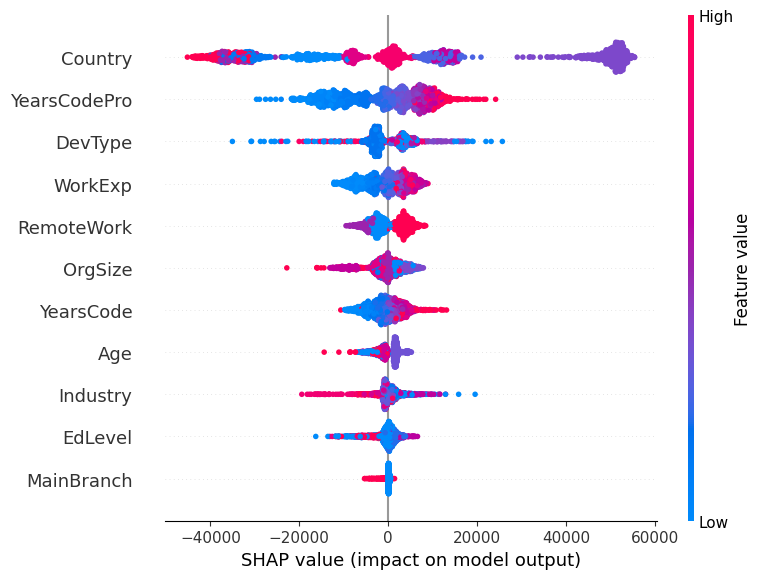

In [6]:
import shap

explainer = shap.Explainer(best_model, X_train_top)

shap_values = explainer(X_test_top)

shap.summary_plot(shap_values, X_test_top)


In [7]:

shap.initjs()  
shap.force_plot(shap_values[0])


In [8]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(best_model, X_test_top, y_test_top, n_repeats=10, random_state=42)

# Get the mean importance and standard deviation for each feature
importance_df = pd.DataFrame({
    'Feature': X_test_top.columns,
    'Importance': result.importances_mean,
    'StdDev': result.importances_std
})

# Sort the importance values
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


         Feature  Importance  StdDev
8        Country        0.90    0.03
5   YearsCodePro        0.08    0.01
6        DevType        0.03    0.00
9        WorkExp        0.02    0.00
7        OrgSize        0.02    0.00
10      Industry        0.02    0.00
2     RemoteWork        0.02    0.00
4      YearsCode        0.01    0.00
3        EdLevel        0.01    0.00
1            Age        0.01    0.00
0     MainBranch        0.00    0.00


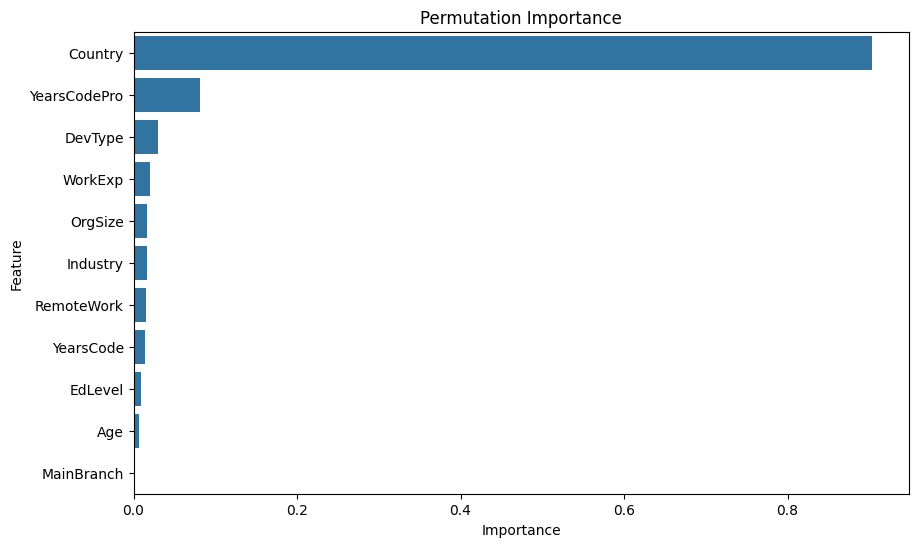

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Permutation Importance')
plt.show()


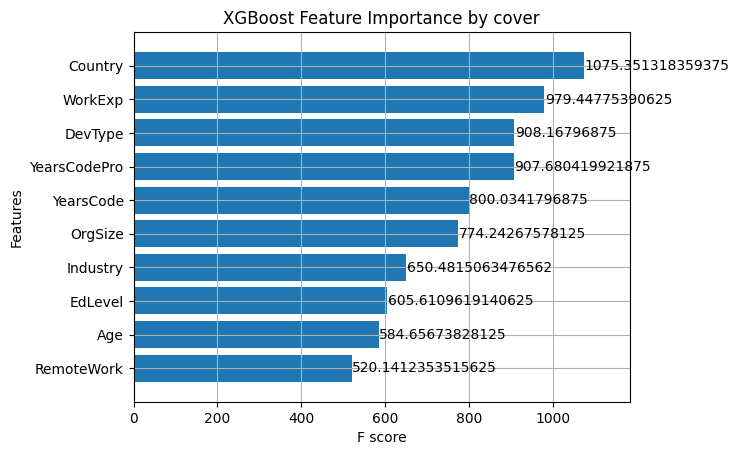

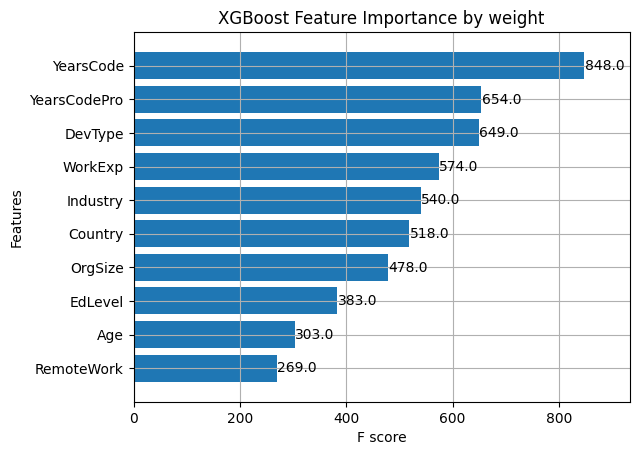

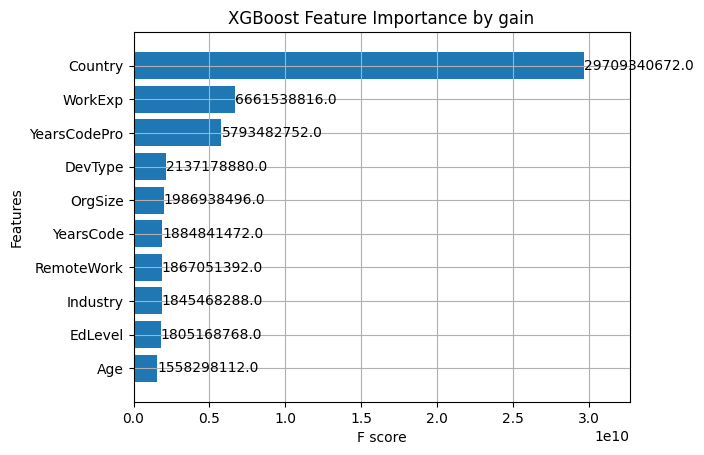

In [10]:
import xgboost as xgb
xgb.plot_importance(model_top, importance_type='cover', max_num_features=10, height=0.8)
plt.title('XGBoost Feature Importance by cover')
plt.show()
xgb.plot_importance(model_top, importance_type='weight', max_num_features=10, height=0.8)
plt.title('XGBoost Feature Importance by weight')
plt.show()

xgb.plot_importance(model_top, importance_type='gain', max_num_features=10, height=0.8)
plt.title('XGBoost Feature Importance by gain')
plt.show()



By using the tools above, I can identify the most influential features are , country, and yearscodepro.

also years code and workexp are important features.

## Explain Model Performance:

In [11]:
baseline_r2 = r2_score(y_test_base, y_pred_base)
baseline_rmse = np.sqrt(mean_squared_error(y_test_base, y_pred_base))
baseline_pearson = np.corrcoef(y_test_base, y_pred_base)[0, 1]

improved_r2 = r2_score(y_test_top, y_pred_best)
improved_rmse = np.sqrt(mean_squared_error(y_test_top, y_pred_best))
improved_pearson = np.corrcoef(y_test_top, y_pred_best)[0, 1]



In [12]:
# Baseline Model
print("Baseline Model Performance:")
print(f"R²: {baseline_r2:.4f}")
print(f"Pearson Correlation: {baseline_pearson:.4f}")
print(f"RMSE: {baseline_rmse:.4f}")

# Improved Model
print("\nImproved Model Performance:")
print(f"R²: {improved_r2:.4f}")
print(f"Pearson Correlation: {improved_pearson:.4f}")
print(f"RMSE: {improved_rmse:.4f}")


Baseline Model Performance:
R²: 0.5973
Pearson Correlation: 0.7736
RMSE: 24369.6794

Improved Model Performance:
R²: 0.6900
Pearson Correlation: 0.8309
RMSE: 27069.8885


The improved model is significantly better than the baseline model in terms of R² and Pearson correlation, suggesting it’s doing a better job of explaining the relationship between the features and the target variable. However, the increase in RMSE suggests that the model’s predictions might be less precise in certain areas, potentially due to overfitting.

## Visualization:

first visulaiztion is comparing the modles prefomance by comparing r2 rmse and pearson correlation.

<Figure size 1000x600 with 0 Axes>

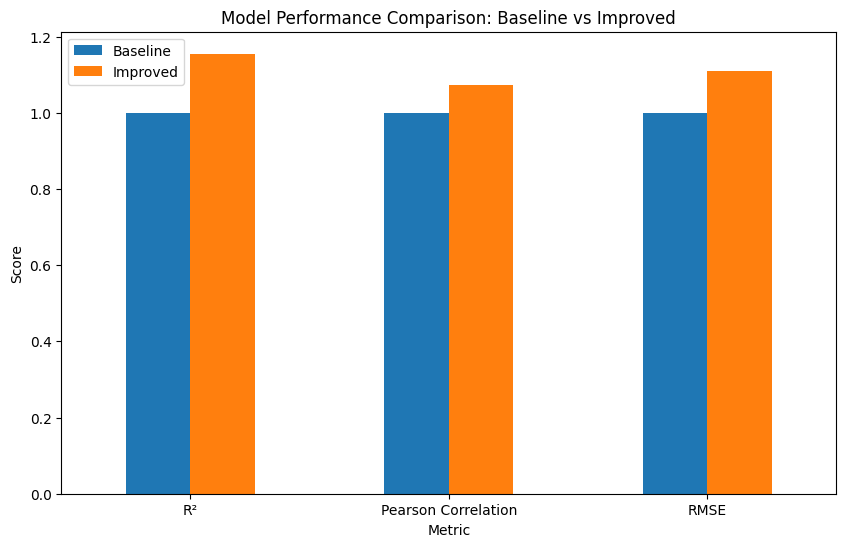

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Performance Comparison Bar Chart
metrics = ['R²', 'Pearson Correlation', 'RMSE']
0.539
baseline_values = [1, 1, 1]
improved_values = [0.6900/0.5973, 0.8309/0.7736, 27069.8885/24369.6794]

performance_df = pd.DataFrame({
    'Metric': metrics,
    'Baseline': baseline_values,
    'Improved': improved_values
})

plt.figure(figsize=(10, 6))
performance_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison: Baseline vs Improved')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


second visulaiztion is comparing the SHAP values for both models.

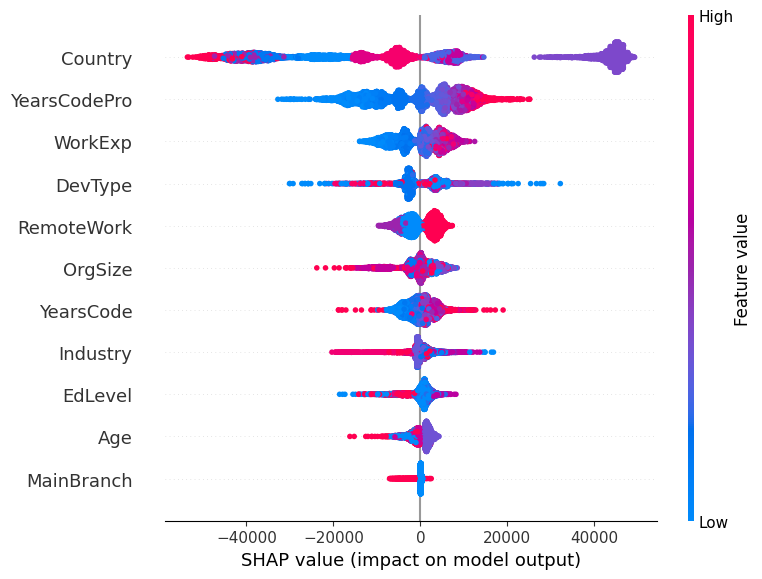

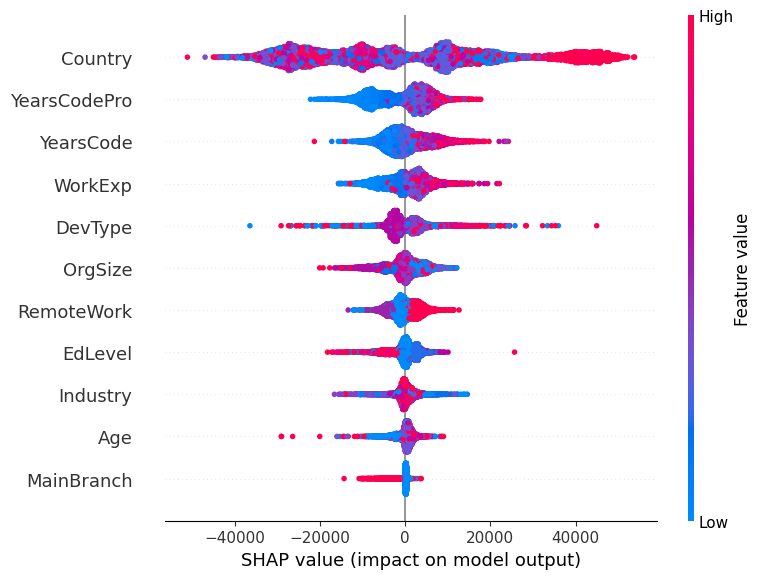

In [14]:

import shap

# Generate SHAP values for the improved model
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_top)

# Plot the feature importance
shap.summary_plot(shap_values, X_train_top)

# Generate SHAP values for the improved model
explainer = shap.Explainer(model_base)
shap_values = explainer(X_train)

# Plot the feature importance
shap.summary_plot(shap_values, X_train)




third visulaiztion is residuals plot for both models compared.

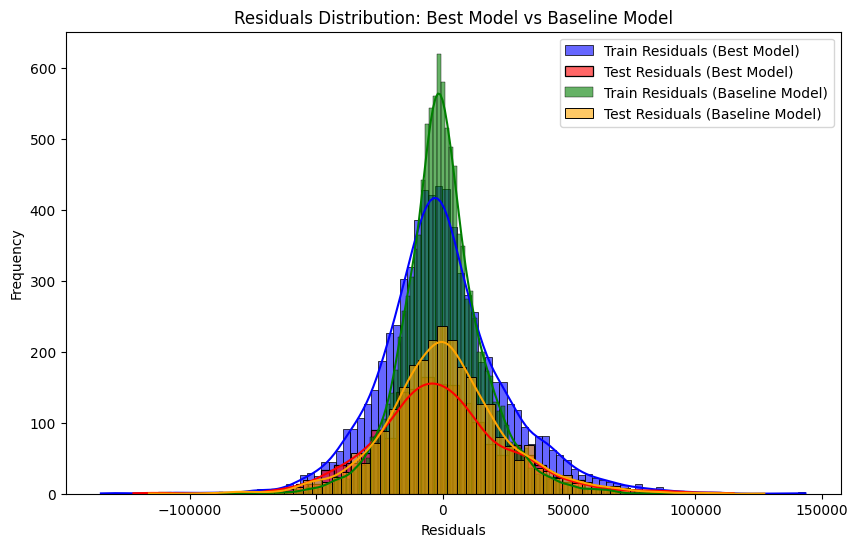

In [15]:
# Predictions for best model
y_train_pred_best = best_model.predict(X_train_top)
y_test_pred_best = best_model.predict(X_test_top)

train_residuals_best = y_train_top - y_train_pred_best
test_residuals_best = y_test_top - y_test_pred_best

# Predictions for baseline model
y_train_pred_base = model_base.predict(X_train)
y_test_pred_base = model_base.predict(X_test)

train_residuals_base = y_train_base - y_train_pred_base
test_residuals_base = y_test_base - y_test_pred_base

# Plotting residuals of both models
plt.figure(figsize=(10, 6))

# Plot residuals for the best model
sns.histplot(train_residuals_best, kde=True, color='blue', label='Train Residuals (Best Model)', alpha=0.6)
sns.histplot(test_residuals_best, kde=True, color='red', label='Test Residuals (Best Model)', alpha=0.6)

# Plot residuals for the baseline model
sns.histplot(train_residuals_base, kde=True, color='green', label='Train Residuals (Baseline Model)', alpha=0.6)
sns.histplot(test_residuals_base, kde=True, color='orange', label='Test Residuals (Baseline Model)', alpha=0.6)

plt.title('Residuals Distribution: Best Model vs Baseline Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()


forth visulaiztion is comparing Predict vs actual values for both models.

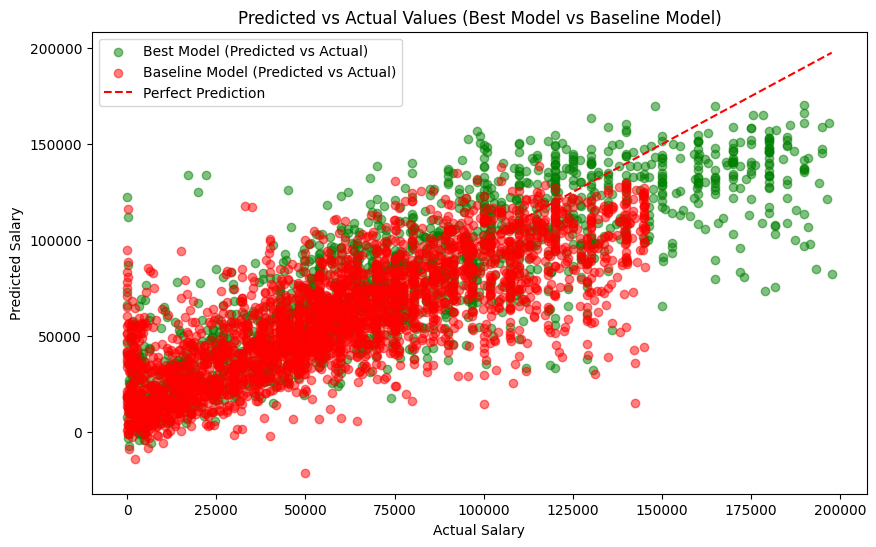

In [16]:
plt.figure(figsize=(10, 6))

# Plot for the best model
plt.scatter(y_test_top, y_test_pred_best, alpha=0.5, color='green', label='Best Model (Predicted vs Actual)')

# Plot for the baseline model
plt.scatter(y_test_base, y_test_pred_base, alpha=0.5, color='red', label='Baseline Model (Predicted vs Actual)')

# Red diagonal line for perfect predictions
plt.plot([min(y_test_top.min(), y_test_base.min()), max(y_test_top.max(), y_test_base.max())], 
         [min(y_test_top.min(), y_test_base.min()), max(y_test_top.max(), y_test_base.max())], 
         color='red', linestyle='--', label='Perfect Prediction')

plt.title('Predicted vs Actual Values (Best Model vs Baseline Model)')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.legend()
plt.show()


# 4. Drawing Conclusions About the Data & Creative Applications

## Feature Significance: Which Features Are Most Influential?

Based on the SHAP values, xgboost and the feature importance analysis, the following features were found to be the most influential in predicting salaries:

YearsCodePro: The number of years of professional coding experience significantly impacts the salary predictions, as expected. Experienced developers tend to have higher salaries, making this feature one of the most important.

Country: The geographical location of a person plays a major role in salary variations. Countries with higher salaries like the United States, Switzerland, and others tend to have more significant salary predictions.

Work Experience: Like YearsCodePro, WorkExp (work experience) also affects salary, but it tends to show how well-rounded a developer is in different job roles over time, influencing the final salary.

## 2. Biases or Trends: Identifiable Patterns or Biases
Geographical Bias: The model indicates a strong geographical bias, where professionals from certain countries with higher average salaries, such as the US , are predicted to earn much higher than those from countries with lower salary averages. This suggests that while professional experience and skills are crucial, location plays a dominant role in salary expectations.

Overemphasis on Years of Experience: The model may overestimate the importance of professional experience (YearsCodePro and WorkExp), which are highly predictive but might not always reflect a person’s potential in tech roles, where continuous learning and adaptability are critical. A bias towards years of experience could lead to underestimating newer developers who bring innovative skills to the table.

## 3. Data Insights: Surprising Findings
Country-Specific Salary Prediction: A surprising finding was that salary prediction based on country alone seemed to dominate the model’s predictions. While experience and education are significant, location appears to have a disproportionately large influence, which could be due to the high variance in salary levels across different regions.

Influence of Education: Education level, though important, was not as influential as expected. This suggests that hands-on coding experience might be a stronger predictor of salary in the tech field compared to formal education. This aligns with the trend where self-taught developers or those from coding bootcamps are increasingly earning comparable salaries to those with formal degrees.

## 4. Applications of the Findings
The insights from this data could be applied in several practical ways:

Real-World Use Cases:

Targeted Marketing Campaigns: Companies could use salary prediction models to target marketing campaigns for specific countries or regions where salaries are lower, thus attracting top-tier talent.

Career Development Platforms: Platforms like LinkedIn, Coursera, or Udemy could use the model to suggest career paths, salary expectations, and required skills based on factors like work experience, country, and industry.

Company Salary Benchmarking: Organizations can use the model to understand how their salary offerings compare with industry standards, based on geographical location, role, and experience level, leading to more competitive compensation packages.

Predictive Tools for Stakeholders:

Recruiters and Hiring Managers: The model can be used as a tool to predict salary offers based on the candidate’s background and role. This can aid in setting appropriate salary expectations during the hiring process.

Salary Negotiation Tools: A salary negotiation tool could be developed that helps individuals know what their expected salary should be, given their experience, education, and location, This could empower employees to negotiate better compensation packages.